## Deep learning approach with price volatility and Gas fees

In [1]:
#Deep learning library of choice PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching

import numpy as np
import scipy.stats as stats
import pandas as pd

# Time to check that the gpu optimization is actually helping

import time 

# Some graphing

import matplotlib.pyplot as plt

In [2]:
# use GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Count the number of CPU cores available, this returns the number of threads, because most cpus have a thread count equal to twice their core count I have halved the count when multithreading
# Set this number to one if you dont want to multi thread the process

cpuCount = os.cpu_count()
print(cpuCount)

cuda:0
24


In [3]:
#Pull the data from the CSV

#This value will allow you to change how many periods back the data will consider. for example if you select 1 it will only look at the previous period, Maximum value is currently set to 8.
#if you want to try over more data periods a greater number of datalet length will need to be preped in the data prep folders

dataperiods = 1

df = pd.read_csv('../dataletswgv/datalet{}.csv'.format(dataperiods+1),index_col=False)


In [4]:
display(df)

,Mev_period0,Mev_period1,gas_fees_period0,gas_fees_period1,price_volitility_period0,price_volitility_period1
0,2.0,1.0,1.0,2.0,0.0,2.0
1,1.0,3.0,2.0,3.0,2.0,1.0
2,3.0,1.0,3.0,2.0,1.0,3.0
3,1.0,3.0,2.0,1.0,3.0,1.0
4,3.0,2.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...
9993,2.0,2.0,0.0,0.0,0.0,2.0
9994,2.0,0.0,0.0,3.0,2.0,1.0
9995,0.0,3.0,3.0,2.0,1.0,0.0
9996,3.0,0.0,2.0,1.0,0.0,3.0


In [5]:
dataheaders = list(df.columns)
dataheaders.remove('Mev_period{}'.format(int((df.shape[1]/3-1))))
dataheaders.remove('gas_fees_period{}'.format(int((df.shape[1]/3-1))))
dataheaders.remove('price_volitility_period{}'.format(int((df.shape[1]/3-1))))

data = torch.Tensor(df[dataheaders].values).type(torch.float)
labels = torch.Tensor(df['Mev_period{}'.format(int((df.shape[1]/3)-1))].values).type(torch.LongTensor)

In [6]:
print(data)
print(labels)

tensor([[2., 1., 0.],
        [1., 2., 2.],
        [3., 3., 1.],
        ...,
        [0., 3., 1.],
        [3., 2., 0.],
        [0., 1., 3.]])
tensor([1, 3, 1,  ..., 3, 0, 1])


In [7]:
# First we are going to split the data into three parts, evaluation, test and training data. I do this with two instances of train_test_split, just for the sake of convinience.

traintemp_data,eval_data, traintemp_labels,eval_labels = train_test_split(data, labels, test_size=.01)

train_data,test_data, train_labels,test_labels = train_test_split(traintemp_data, traintemp_labels, test_size=.011)

#then we are going to pass the data to the Pytorch data loader, this is going to allow us to split it into mini batches that will be run through the model.

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

train_data = train_data
test_data = test_data

#Best to keep batches to powers of two for speed reasons adjust as needed for your own memory constraints 
x = 10
batches   = 2**x
train_loader = DataLoader(train_data,batch_size=batches,shuffle=True,drop_last=True, num_workers=(int(cpuCount/2)))
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) 

In [8]:
# create a class for the model

class ANN(nn.Module):
	def __init__(self, Input_dim, Output_dim):
		super().__init__()

		### input layer
		self.input = nn.Linear(Input_dim,4)
		
		### hidden layers
		self.hidden1    = nn.Linear(4,4)
		self.bnorm1 = nn.BatchNorm1d(4) 
		self.hidden2    = nn.Linear(4,4)
		self.bnorm2 = nn.BatchNorm1d(4) 
		self.hidden3    = nn.Linear(4,4)
		self.bnorm3 = nn.BatchNorm1d(4)
		self.hidden4    = nn.Linear(4,4)

		### output layer
		self.output = nn.Linear(4,Output_dim)
	
	# forward pass
	def forward(self,x):

		# input (x starts off normalized)
		x = F.relu( self.input(x) )


		# hidden layer 1
		x = self.bnorm1(x) # batchnorm
		x = F.relu( self.hidden1(x) )      # linear function and activation function

		# hidden layer 2
		x = self.bnorm2(x) # batchnorm
		x = F.relu( self.hidden2(x) )      # linear function and activation function
		
		# hidden layer 3
		x = self.bnorm3(x)
		x = F.relu( self.hidden3(x) )      # linear function and activation function
  
		# hidden layer 4

		x = F.relu( self.hidden4(x) )

		# output layer
		return self.output(x)

In [9]:
def trainthemodel():
	
	# Loss function and optimizer, I chose cross entropy loss as it is best for classification problems. 
	lossfun = nn.CrossEntropyLoss()
	optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
	
	#initialize losses
	losses = torch.zeros(numofepochs)
	trainAcc = []
	testAcc = []

	model.to(device)
	
	#now lets actually loop over the training epochs to train the model
	for epoch in range(numofepochs):
		
		# switch on training mode
		model.train()

		# loop over training data batches
		batchAcc  = []
		batchLoss = []
		for X,y in train_loader:

			X = X.to(device)
			y = y.to(device)
			
			# forward pass and loss
			yHat = model(X)
			loss = lossfun(yHat,y)

			# backprop
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# loss from this batch
			batchLoss.append(loss.item())

			yHat = yHat.cpu()
			y = y.cpu()

			# compute training accuracy for this batch
			batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
			
		# now that we've trained through the batches, get their average training accuracy
		trainAcc.append( np.mean(batchAcc)) 

		# and get average losses across the batches
		losses[epoch] = np.mean(batchLoss)
		
		### test accuracy

		# Lets turn eval back on so we dont overfit with the test data 
		model.eval()
		X,y = next(iter(test_loader)) # extract X,y from test dataloader

		X = X.to(device)
		y = y.to(device)  

		with torch.no_grad(): # deactivates autograd
			yHat = model(X)
   
		yHat = yHat.cpu()
		y = y.cpu()   

		testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()) )

		print('epoch {} done at time {} '.format(epoch,time.perf_counter()))


	# function output
	return trainAcc,testAcc,losses,model

In [10]:
# Time to run the model, first we need to input parameters, you might want to change the number of epochs if it isn't reaching the level of accuracy desired.

input_dim = df.shape[1]-3
output_dim = 4
numofepochs = 1000


model = ANN(Input_dim = input_dim,Output_dim = output_dim)
trainAcc,testAcc,losses,model = trainthemodel()

epoch 0 done at time 7.8020382 
epoch 1 done at time 9.7676795 
epoch 2 done at time 11.7797321 
epoch 3 done at time 13.75928 
epoch 4 done at time 15.7800036 
epoch 5 done at time 17.7468301 
epoch 6 done at time 19.7080912 
epoch 7 done at time 21.711525 
epoch 8 done at time 23.759843 
epoch 9 done at time 25.8509684 
epoch 10 done at time 27.8164145 
epoch 11 done at time 29.8071391 
epoch 12 done at time 31.7832659 
epoch 13 done at time 33.78973 
epoch 14 done at time 35.750316 
epoch 15 done at time 37.7788203 
epoch 16 done at time 39.7677126 
epoch 17 done at time 41.7965618 
epoch 18 done at time 43.8159898 
epoch 19 done at time 45.7898757 
epoch 20 done at time 47.8107728 
epoch 21 done at time 49.8910674 
epoch 22 done at time 51.9600521 
epoch 23 done at time 53.9879826 
epoch 24 done at time 56.0213871 
epoch 25 done at time 58.0585863 
epoch 26 done at time 60.0970105 
epoch 27 done at time 62.1299827 
epoch 28 done at time 64.1456519 
epoch 29 done at time 66.1647964 

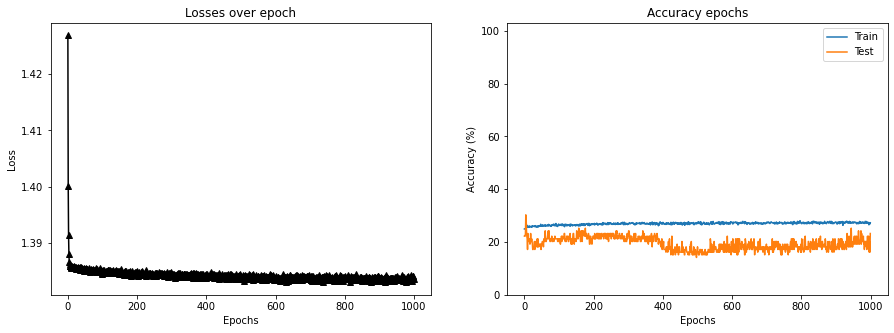

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,5))



ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses over epoch')

ax[1].plot(trainAcc,)
ax[1].plot(testAcc,)
ax[1].set_title('Accuracy epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([0,103])

plt.show()



In [18]:
# Computing the final accuracy, if using sample data, this should be around 25% as there is no structure to the data. 

# because its a small batch we can just run this on the CPU

model.to('cpu')

100*torch.mean((torch.argmax(model(eval_data),axis=1) == eval_labels).float()).item()

33.000001311302185